# Cluster Assignment
___

In [1]:
clustering_strategy = 'BGMM'

## Setup

### Importing Packages

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from astronomaly.dimensionality_reduction import pca
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import BayesianGaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from umap import UMAP

### Directories

In [3]:
# Data Root Directory
data_root_dir = os.path.join(os.getcwd(), 'Data')

# Label Directory
assigned_label_dir = os.path.join(data_root_dir, 'assigned_volunteer_labels.parquet')

# Image Directory
img_dir = os.path.join(data_root_dir, 'DeCaLs')

# PCA Feature Directory
pca_feature_dir = os.path.join(data_root_dir, 'pca_features.parquet')

In [4]:
pca_features = pd.read_parquet(pca_feature_dir)
print('PCA: ', pca_features.shape)

PCA:  (230575, 29)


## Fitting

In [5]:
if clustering_strategy == 'MiniBatchKMeans':
    # Perform fit
    my_kmeans = MiniBatchKMeans(n_clusters=20, max_iter=10, n_init="auto").fit(pca_features)
    # Predict Labels, Centers and Distances
    kmeans_labels = my_kmeans.predict(pca_features)
    kmeans_centers = my_kmeans.cluster_centers_
    kmeans_dist = my_kmeans.transform(pca_features)
    # Create Distance Column Names
    dist_cols = []
    for i in range(kmeans_dist.shape[1]):
        dist_cols.append(f'Distance_{i}')
    # Saving cluster distance information
    clusters = pd.DataFrame(index = pca_features.index.copy())
    clusters['Cluster'] = kmeans_labels
    clusters['Center'] = [list(kmeans_centers[i]) for i in kmeans_labels]
    clusters[dist_cols] = kmeans_dist
    print(f'{clustering_strategy} clusters with distance: ', clusters.shape)

    ########################################
    ## Convert Distances to Probabilities
    ########################################
    ## Smaller Distance = Big Score (dist = 100 -> score = -100) 
    #scores = -clusters_dist[dist_cols].values 
    ## Normalize scores to probabilities
    #exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
    ## Softmax Probabilities
    #probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    ## Create Probability Column Names
    #prob_cols = []
    #for i in range(kmeans_dist.shape[1]):
    #    prob_cols.append(f'Prob_{i}')
    ## Saving cluster probability information
    #clusters[dist_cols] = probs
    #print(f'{clustering_strategy} clusters with probability: ', clusters.shape)

elif clustering_strategy == 'BGMM':
    # Perform fit
    my_bgmm = BayesianGaussianMixture(n_components=20, weight_concentration_prior=0.5, n_init=10, max_iter=1000).fit(pca_features)
    # Predict Labels, Centers and Probabilities
    bgm_labels = my_bgmm.predict(pca_features)
    bgm_centers = my_bgmm.means_
    bgm_prob = my_bgmm.predict_proba(pca_features)
    # Create Probability Column Names
    prob_cols = []
    for i in range(bgm_prob.shape[1]):
        prob_cols.append(f'Prob_{i}')
    # Saving cluster probability information
    clusters = pd.DataFrame(index = pca_features.index.copy())
    clusters['Cluster'] = bgm_labels
    clusters['Center'] = [list(bgm_centers[i]) for i in bgm_labels]
    clusters[prob_cols] = bgm_prob
    print(f'{clustering_strategy} clusters with probability: ', clusters.shape)

BGMM clusters with probability:  (230575, 22)


### Filtering for Common Labels

In [8]:
volunteer_labels = pd.read_parquet(assigned_label_dir)
print('Volunteer Labels: ', volunteer_labels.shape)

Volunteer Labels:  (14960, 134)


In [9]:
# Filter to only common labels
common_labels = clusters.index.intersection(volunteer_labels.index)
print('Common Labels: ', len(common_labels))
# Filtering Volunteer Labels
filtered_volunteer_labels = volunteer_labels.loc[common_labels]
filtered_volunteer_labels.index.name= 'iauname'
# Filtering Cluster Assignments
filtered_clusters = clusters.loc[common_labels]
# Combine and save filtered data
test_subset = pd.concat([filtered_clusters, filtered_volunteer_labels], axis=1)
test_subset.to_parquet(os.path.join(data_root_dir, f'{clustering_strategy}_test_subset.parquet'))
print('Filtered Cluster Assignment and Labels: ', test_subset.shape)

Common Labels:  10624
Filtered Cluster Assignment and Labels:  (10624, 156)


## Plotting

### Cluster Plots

<Axes: xlabel='Cluster', ylabel='smooth-or-featured_featured-or-disk_fraction'>

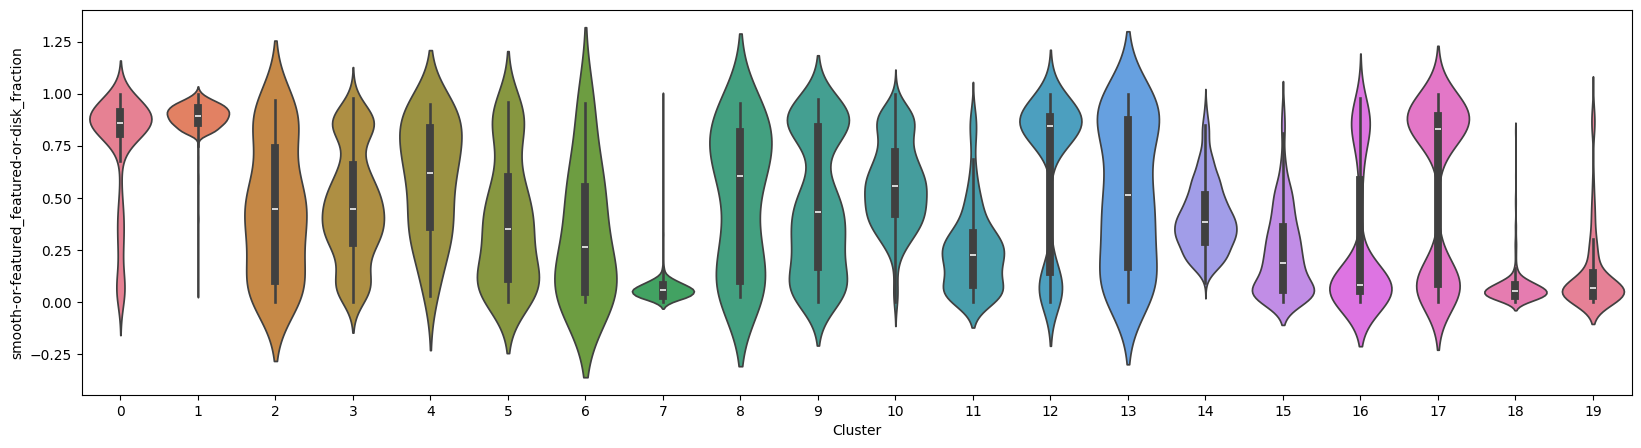

In [10]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='smooth-or-featured_featured-or-disk_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='how-rounded_cigar-shaped_fraction'>

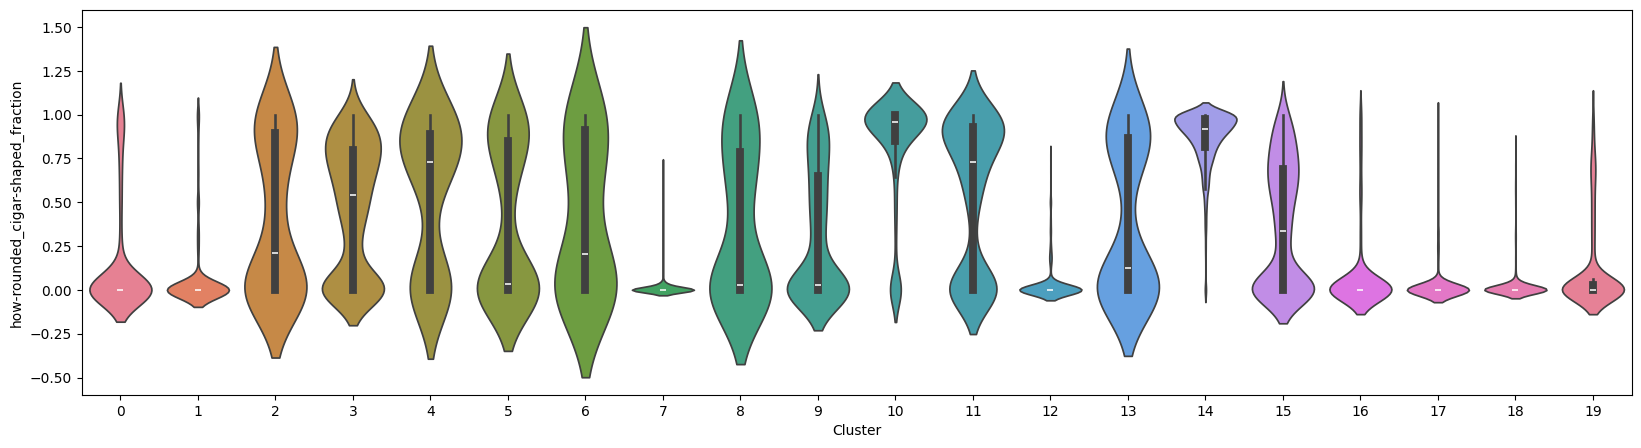

In [11]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='how-rounded_cigar-shaped_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='disk-edge-on_yes_fraction'>

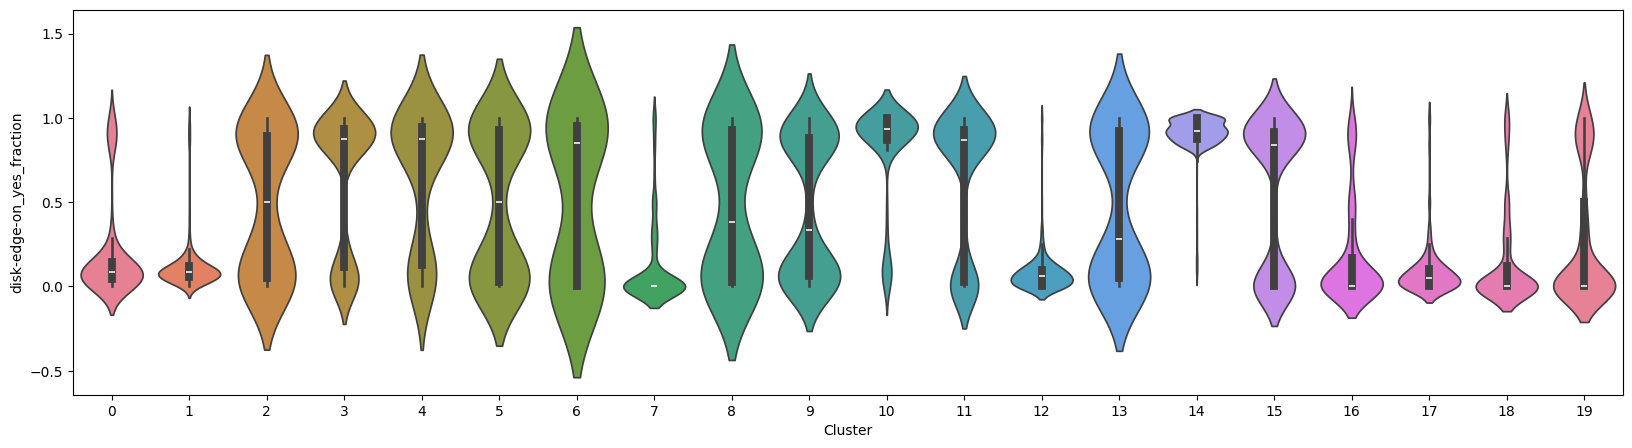

In [12]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='disk-edge-on_yes_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='bulge-size_dominant_fraction'>

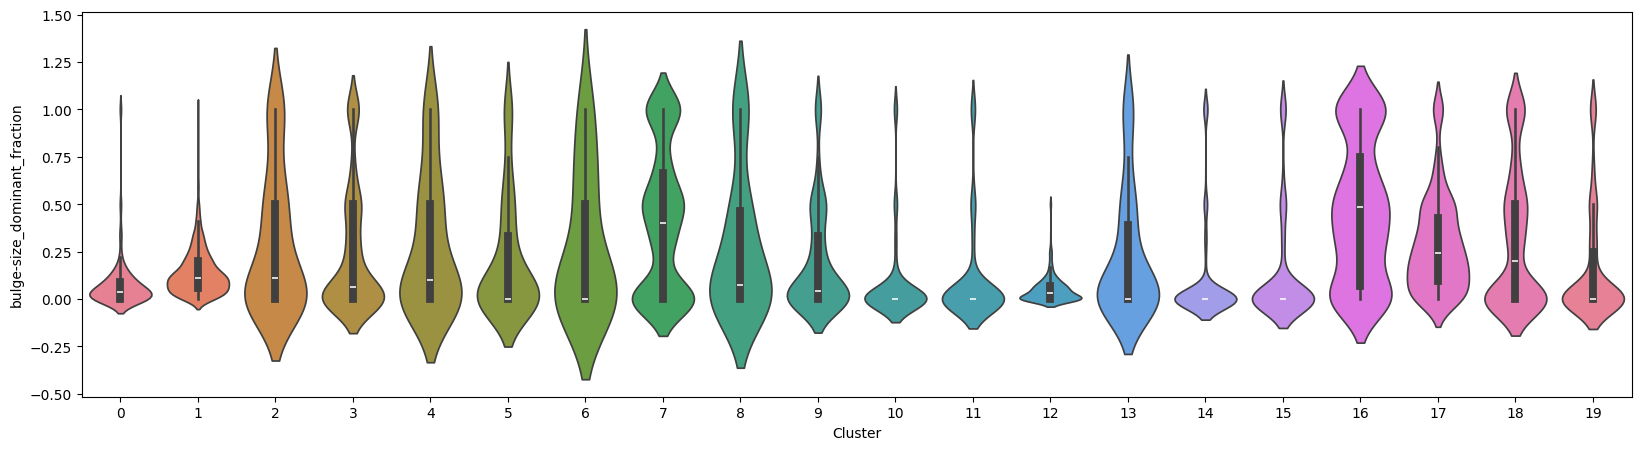

In [13]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='bulge-size_dominant_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='merging_neither_fraction'>

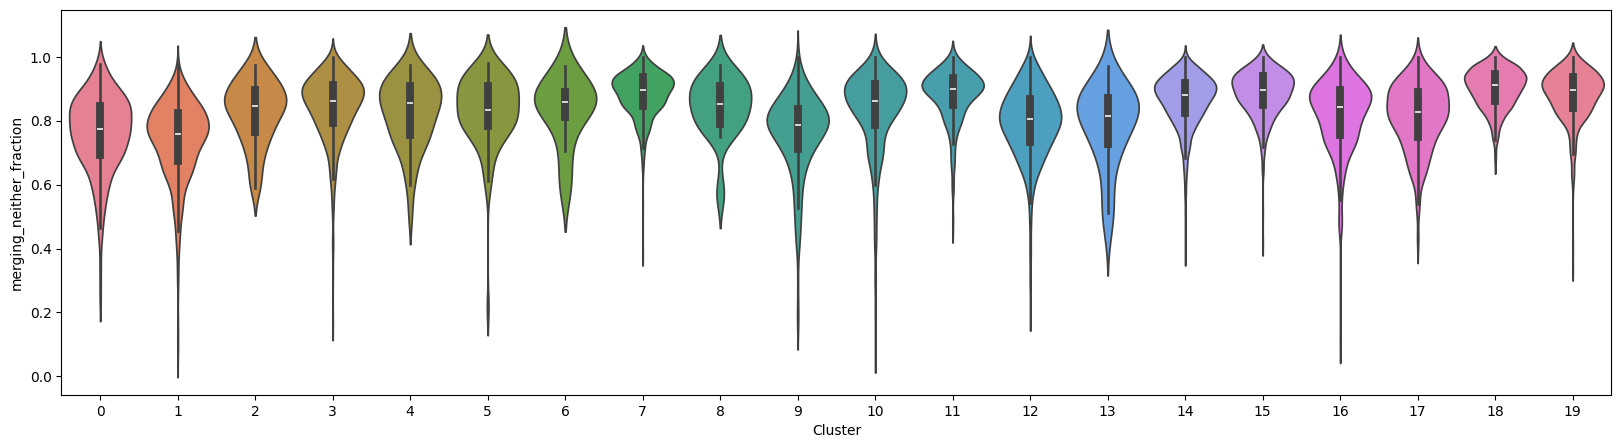

In [14]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='merging_neither_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

### UMAP Plot for MiniBatchKMeans

/home/kirsten/Project/my_proj_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


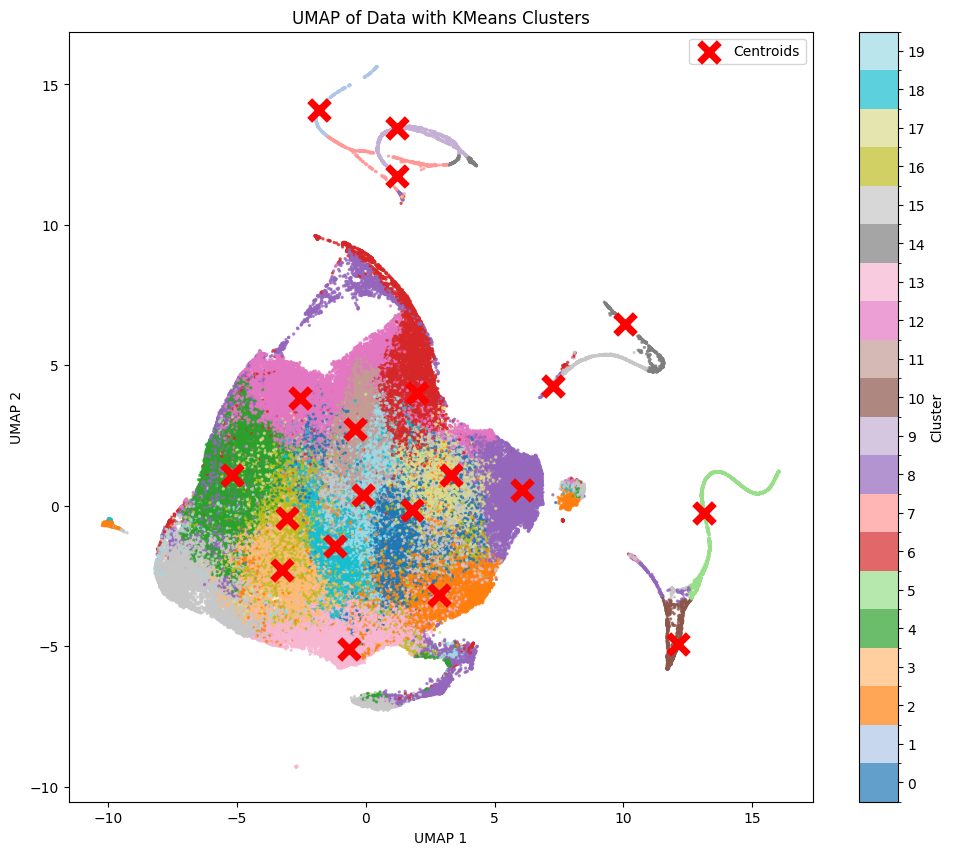

In [29]:
if clustering_strategy == 'MiniBatchKMeans':
    umap = UMAP(n_components=2, random_state=42)
    umap_features = umap.fit_transform(pca_features)
    centers_umap = umap.transform(kmeans_centers)
    kmeans_labels = kmeans_labels.astype(int)
    n_clusters = len(set(kmeans_labels))
    #colors = plt.cm.get_cmap('tab20', n_clusters)
    colors = plt.colormaps.get_cmap('tab20')
    cmap = ListedColormap(colors.colors[:n_clusters])
    norm = BoundaryNorm(boundaries= np.arange(-0.5,n_clusters+0.5,1), ncolors=n_clusters)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], c=kmeans_labels, cmap=cmap, norm=norm,s=2, alpha=0.7)
    plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster')
    plt.scatter(centers_umap[:, 0], centers_umap[:, 1], c='red', s=200, linewidth=5, marker='x', label='Centroids')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP of Data with KMeans Clusters')
    plt.legend()
    plt.show()